In [4]:
import os
import random
import numpy as np
import pylab as plt
%matplotlib inline

import sys
sys.path.insert(0,'../')

import csgan as cs


In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../dataset/mnist/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../../dataset/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../../dataset/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../dataset/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../dataset/mnist/t10k-labels-idx1-ubyte.gz


In [6]:
x_train = mnist.train.images[:55000,:]
x_train.shape

class data_provider(object):
    def __init__(self,x_train):
        self.x_train = x_train
        self.num = x_train.shape[0]
        
    def __call__(self,n):
        n_list = np.arange(self.num)
        random.shuffle(n_list)
        return self.x_train[n_list[:n]].reshape(n,28,28,1)
        

(0.9960785, 0.0)


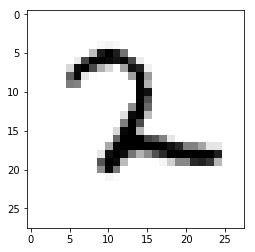

In [17]:
dp = data_provider(x_train)
    
image = dp(10)[0].reshape([28,28])
print(image.max(), image.min())
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [8]:
dp(10).shape

(10, 28, 28, 1)

In [ ]:
dcgan = cs.DCGAN(
    data_provider = lambda x : 2. * dp(x) - 1.,
    data_postprocess = lambda x : .5 * x + .5,
    batch_size=128,
    gf_dim=16, df_dim=8,
    z_dim=100,
    checkpoint_dir='./checkpoint/',save_per = 100)

dcgan.train(num_epoch=10,batch_per_epoch = 50000/128,verbose=100)

Output size is same as input's!
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument 

In [2]:
import tensorflow as tf

input1 = tf.random_normal([1,10,10,32])
input2 = tf.random_normal([1,20,20,32])

def conv_relu(input, kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = tf.get_variable("weights", kernel_shape,
        initializer=tf.random_normal_initializer())
    # Create variable named "biases".
    biases = tf.get_variable("biases", bias_shape,
        initializer=tf.constant_initializer(0.0))
    conv = tf.nn.conv2d(input, weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)


def my_image_filter(input_images):
    with tf.variable_scope("conv1"):
        # Variables created here will be named "conv1/weights", "conv1/biases".
        relu1 = conv_relu(input_images, [5, 5, 32, 32], [32])
    with tf.variable_scope("conv2"):
        # Variables created here will be named "conv2/weights", "conv2/biases".
        return conv_relu(relu1, [5, 5, 32, 32], [32])


with tf.variable_scope("model"):
    output1 = my_image_filter(input1)
with tf.variable_scope("model", reuse=True):
    output2 = my_image_filter(input2)


In [3]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

[u'random_normal/shape',
 u'random_normal/mean',
 u'random_normal/stddev',
 u'random_normal/RandomStandardNormal',
 u'random_normal/mul',
 u'random_normal',
 u'random_normal_1/shape',
 u'random_normal_1/mean',
 u'random_normal_1/stddev',
 u'random_normal_1/RandomStandardNormal',
 u'random_normal_1/mul',
 u'random_normal_1',
 u'model/conv1/weights/Initializer/random_normal/shape',
 u'model/conv1/weights/Initializer/random_normal/mean',
 u'model/conv1/weights/Initializer/random_normal/stddev',
 u'model/conv1/weights/Initializer/random_normal/RandomStandardNormal',
 u'model/conv1/weights/Initializer/random_normal/mul',
 u'model/conv1/weights/Initializer/random_normal',
 u'model/conv1/weights',
 u'model/conv1/weights/Assign',
 u'model/conv1/weights/read',
 u'model/conv1/biases/Initializer/Const',
 u'model/conv1/biases',
 u'model/conv1/biases/Assign',
 u'model/conv1/biases/read',
 u'model/conv1/Conv2D',
 u'model/conv1/add',
 u'model/conv1/Relu',
 u'model/conv2/weights/Initializer/random_nor